In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pwd
%cd "drive/My Drive/CVProject"
!pwd

/content
/content/drive/My Drive/CVProject
/content/drive/My Drive/CVProject


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:


import keras
from keras.layers.core import Layer
import keras.backend as K
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten
from keras.layers import Input, merge, Dropout, Dense, Lambda, Flatten, Activation
from keras.layers.convolutional import MaxPooling2D, Convolution2D, AveragePooling2D
import cv2 
import numpy as np 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler
from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path, PureWindowsPath
from keras.layers.normalization import BatchNormalization

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
def inception_resnet_stem(input):
    if K.image_dim_ordering() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    # Input Shape is 299 x 299 x 3 (th) or 3 x 299 x 299 (th)
    c = Convolution2D(32, 3, 3, activation='relu', subsample=(2, 2))(input)
    c = Convolution2D(32, 3, 3, activation='relu', )(c)
    c = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(c)

    c1 = MaxPooling2D((3, 3), strides=(2, 2))(c)
    c2 = Convolution2D(96, 3, 3, activation='relu', subsample=(2, 2))(c)

    m = merge([c1, c2], mode='concat', concat_axis=channel_axis)

    c1 = Convolution2D(64, 1, 1, activation='relu', border_mode='same')(m)
    c1 = Convolution2D(96, 3, 3, activation='relu', )(c1)

    c2 = Convolution2D(64, 1, 1, activation='relu', border_mode='same')(m)
    c2 = Convolution2D(64, 7, 1, activation='relu', border_mode='same')(c2)
    c2 = Convolution2D(64, 1, 7, activation='relu', border_mode='same')(c2)
    c2 = Convolution2D(96, 3, 3, activation='relu', border_mode='valid')(c2)

    m2 = merge([c1, c2], mode='concat', concat_axis=channel_axis)

    p1 = MaxPooling2D((3, 3), strides=(2, 2), )(m2)
    p2 = Convolution2D(192, 3, 3, activation='relu', subsample=(2, 2))(m2)

    m3 = merge([p1, p2], mode='concat', concat_axis=channel_axis)
    m3 = BatchNormalization(axis=channel_axis)(m3)
    m3 = Activation('relu')(m3)
    return m3

In [0]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [0]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [0]:


input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(21, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(21, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(21, activation='softmax', name='output')(x)



In [0]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [0]:
epochs = 300
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

In [0]:
def data_generator(dataset, batch_size=64):
  print(f'Generating "{dataset}" dataset')
  image_data_gen = ImageDataGenerator(rescale=1/255.0)
  image_generator = image_data_gen.flow_from_directory(target_dirs[dataset],
                                                        batch_size=batch_size,
                                                        target_size=(224, 224),
                                                        shuffle=False)
  
  image_count = 0
  X_batches, Y_batches = [], []
  for X, Y in image_generator:
    X_batches.append(X)
    Y_batches.append(Y)
    image_count += X.shape[0]
    # Must interrupt image_generator
    if image_count >= image_generator.n:
      break
  X = np.concatenate(X_batches)
  Y = np.concatenate(Y_batches)
  return X, Y

In [0]:
## ADD CODE TO GET DATA 

class_names = os.listdir('UCMerced_LandUse/Train/')
target_dirs = {target: './UCMerced_LandUse/' + target for target in ['Train', 'Validation', 'Test']}


In [0]:

num_classes = 21
X, Y = dict(), dict()
for dataset in [ 'Validation', 'Test', 'Train']:
    # 
    X[dataset], Y[dataset] =  data_generator(dataset)

Generating "Validation" dataset
Found 210 images belonging to 21 classes.
Generating "Test" dataset
Found 210 images belonging to 21 classes.
Generating "Train" dataset
Found 1785 images belonging to 21 classes.


In [0]:
#history = model.fit(X_train, [Y_train, Y_train, Y_train], validation_data=(X_valid, [Y_valid, Y_valid, Y_valid]), epochs=epochs, batch_size=256, callbacks=[lr_sc])

model_fit_history = model.fit(X['Train'], [Y['Train'],Y['Train'],Y['Train']], batch_size=64, epochs=300,
                              verbose=2, validation_data=(X['Validation'], [Y['Validation'],Y['Validation'],Y['Validation']]))

Train on 1785 samples, validate on 210 samples
Epoch 1/300
 - 37s - loss: 5.0566 - output_loss: 3.1933 - auxilliary_output_1_loss: 3.0953 - auxilliary_output_2_loss: 3.1144 - output_accuracy: 0.0420 - auxilliary_output_1_accuracy: 0.0577 - auxilliary_output_2_accuracy: 0.0459 - val_loss: 4.9231 - val_output_loss: 3.0576 - val_auxilliary_output_1_loss: 3.0598 - val_auxilliary_output_2_loss: 3.0474 - val_output_accuracy: 0.0476 - val_auxilliary_output_1_accuracy: 0.0476 - val_auxilliary_output_2_accuracy: 0.0476
Epoch 2/300
 - 23s - loss: 4.9554 - output_loss: 3.1231 - auxilliary_output_1_loss: 3.0529 - auxilliary_output_2_loss: 3.0547 - output_accuracy: 0.0459 - auxilliary_output_1_accuracy: 0.0426 - auxilliary_output_2_accuracy: 0.0476 - val_loss: 4.8853 - val_output_loss: 3.0509 - val_auxilliary_output_1_loss: 3.0357 - val_auxilliary_output_2_loss: 3.0388 - val_output_accuracy: 0.0476 - val_auxilliary_output_1_accuracy: 0.0476 - val_auxilliary_output_2_accuracy: 0.0476
Epoch 3/300
 - 

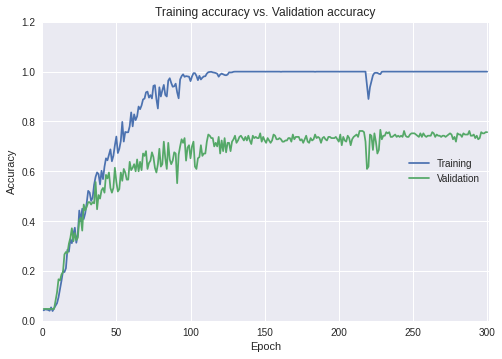

In [0]:
import matplotlib
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['output_accuracy'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['output_accuracy'])
plt.plot(x, model_fit_history.history['val_output_accuracy'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

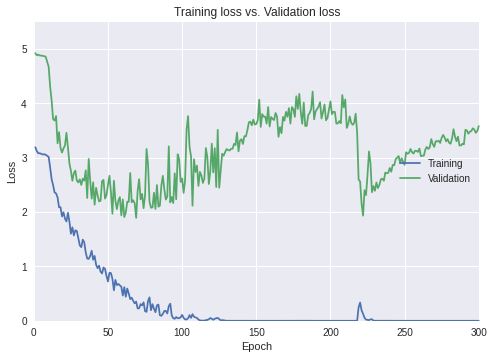

In [0]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['output_loss'])
max_loss = max(max(model_fit_history.history['output_loss']), max(model_fit_history.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['output_loss'])
plt.plot(x, model_fit_history.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

In [0]:
predictions = model.predict(X['Test'])
y_pred = predictions[0]

y_pred_final = y_pred.argmax(axis = -1)

y_test = Y['Test']
ct = []
cp = []
acc = 0 
for i in range(y_test.shape[0]):
  class_true = np.where(y_test[i] == np.amax(y_test[i]))[0][0]
  ct.append(class_true)
  class_pred = y_pred_final[i]
  cp.append(class_pred)
  if class_true == class_pred:
   acc = acc + 1

accuracy = acc / y_test.shape[0]


In [0]:
print(accuracy)

0.7095238095238096


In [0]:

print(accuracy_score(ct, cp))
print(classification_report(ct, cp))

0.7095238095238096
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.40      0.57        10
           2       0.59      1.00      0.74        10
           3       0.86      0.60      0.71        10
           4       0.86      0.60      0.71        10
           5       1.00      1.00      1.00        10
           6       0.55      0.60      0.57        10
           7       0.71      1.00      0.83        10
           8       0.83      0.50      0.62        10
           9       0.56      0.50      0.53        10
          10       0.91      1.00      0.95        10
          11       0.64      0.90      0.75        10
          12       0.33      0.20      0.25        10
          13       0.88      0.70      0.78        10
          14       0.75      0.90      0.82        10
          15       0.77      1.00      0.87        10
          16       0.62      0.50      0.56        10
        